**Install necessary dependencies**

In [1]:
# Install necessary dependencies
!pip install torch torchvision
!pip install matplotlib
!pip install numpy


**Import libraries**

In [5]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torchvision
from torchvision import transforms, datasets


**Prepare a color image dataset**

In [6]:
#  Prepare a color image dataset
# Using CIFAR-10 for example; you can replace this with another dataset if needed.
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resizing images
    transforms.ToTensor(),       # Convert to PyTorch tensor
])

dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

classes = dataset.classes  # List of class labels


100%|██████████| 170M/170M [00:18<00:00, 9.04MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


**Define a conditional image generator**

In [4]:
# Define a conditional image generator
class ConditionalGenerator(nn.Module):
    def __init__(self):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(10, 100)  # Embedding for class condition

        self.model = nn.Sequential(
            nn.Linear(100 + 100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 32 * 32),  # Output for 3 color channels
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        combined_input = torch.cat((noise, label_input), -1)
        output = self.model(combined_input)
        return output.view(output.size(0), 3, 32, 32)


In [7]:
# Training loop
device = 'cuda' if torch.cuda.is_available() else 'cpu'

generator = ConditionalGenerator().to(device)
criterion = nn.MSELoss()  # Loss function
optimizer = optim.Adam(generator.parameters(), lr=0.0002)

epochs = 100
for epoch in range(epochs):
    for i, (real_images, labels) in enumerate(dataloader):
        real_images, labels = real_images.to(device), labels.to(device)
        noise = torch.randn(labels.size(0), 100).to(device)

        optimizer.zero_grad()
        generated_images = generator(noise, labels)

        # Use a placeholder loss (modify for your actual application)
        loss = criterion(generated_images, real_images)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")


Epoch [1/100], Step [100/782], Loss: 0.0619
Epoch [1/100], Step [200/782], Loss: 0.0647
Epoch [1/100], Step [300/782], Loss: 0.0550
Epoch [1/100], Step [400/782], Loss: 0.0662
Epoch [1/100], Step [500/782], Loss: 0.0495
Epoch [1/100], Step [600/782], Loss: 0.0587
Epoch [1/100], Step [700/782], Loss: 0.0564
Epoch [2/100], Step [100/782], Loss: 0.0658
Epoch [2/100], Step [200/782], Loss: 0.0601
Epoch [2/100], Step [300/782], Loss: 0.0488
Epoch [2/100], Step [400/782], Loss: 0.0599
Epoch [2/100], Step [500/782], Loss: 0.0593
Epoch [2/100], Step [600/782], Loss: 0.0539
Epoch [2/100], Step [700/782], Loss: 0.0569
Epoch [3/100], Step [100/782], Loss: 0.0505
Epoch [3/100], Step [200/782], Loss: 0.0647
Epoch [3/100], Step [300/782], Loss: 0.0546
Epoch [3/100], Step [400/782], Loss: 0.0667
Epoch [3/100], Step [500/782], Loss: 0.0622
Epoch [3/100], Step [600/782], Loss: 0.0596
Epoch [3/100], Step [700/782], Loss: 0.0610
Epoch [4/100], Step [100/782], Loss: 0.0596
Epoch [4/100], Step [200/782], L

**Display a Batch of Images with Conditions**

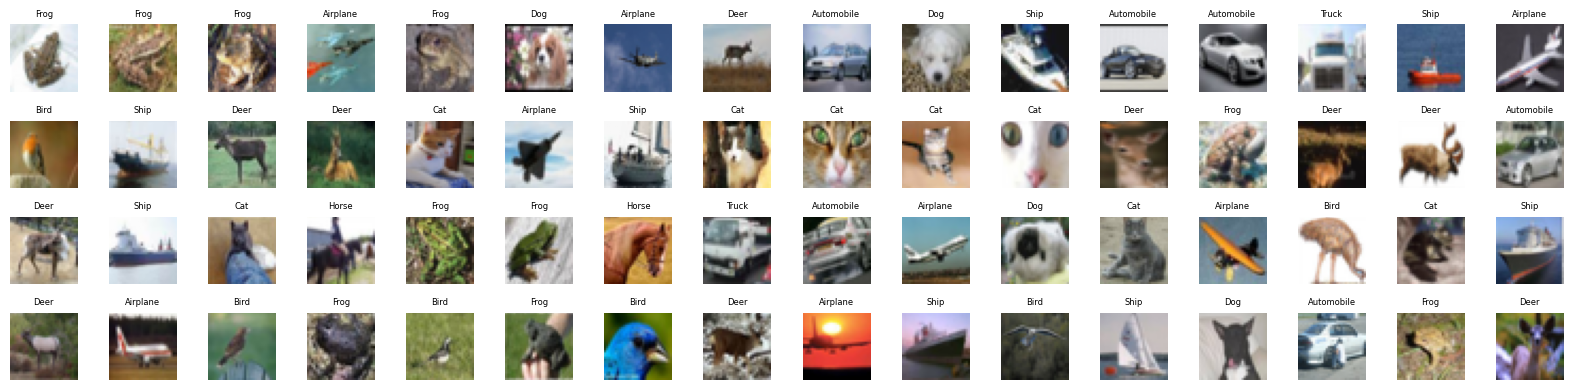

In [17]:
# Fetch a batch of images and labels
images, labels = next(iter(train_loader))
images = images.numpy()  # Convert to NumPy for visualization

# Label names for CIFAR-10
label_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Set up a 4x16 grid of subplots
fig, axes = plt.subplots(4, 16, figsize=(16, 4), sharex=True, sharey=True)

for i in range(4):  # Loop over rows
    for j in range(16):  # Loop over columns
        index = i * 16 + j  # Calculate the index in the batch
        image = images[index].transpose(1, 2, 0)  # Convert to HWC format
        label = labels[index].item()  # Get label for the image
        axes[i, j].imshow((image * 0.5 + 0.5))  # Rescale pixel values for visualization
        axes[i, j].set_title(label_names[label], fontsize=6)  # Display label as title
        axes[i, j].axis('off')  # Turn off axis labels and ticks

plt.tight_layout()
plt.show()

**Add Conditional Image Generation**

In [20]:
def generate_conditioned_image(condition, dataset, label_names):
    """
    Generates a conditioned image by modifying colors of an image from CIFAR-10.
    Args:
        condition (str): The condition to apply (e.g., "Cat", "Automobile").
        dataset (Dataset): The CIFAR-10 dataset.
        label_names (list): List of label names corresponding to the dataset.
    Returns:
        numpy.ndarray: A conditioned color image (HWC format).
    """
    # Find index of the condition in label names
    condition_index = label_names.index(condition.capitalize())

    # Select an image matching the condition
    for image, label in dataset:
        if label == condition_index:
            # Convert image to NumPy array for modification
            image_np = image.numpy().transpose(1, 2, 0)  # Convert to HWC
            break

    # Apply condition-specific color modifications
    if condition.lower() == 'cat':
        image_np[:, :, 0] *= 1.5  # Enhance the red channel
    elif condition.lower() == 'automobile':
        image_np[:, :, 2] *= 1.5  # Enhance the blue channel
    elif condition.lower() == 'bird':
        image_np[:, :, 1] *= 1.5  # Enhance the green channel
    else:
        image_np *= 0.8  # Slightly dim images for unknown conditions

    # Clip values to valid range [0, 1]
    image_np = np.clip(image_np, 0, 1)
    return image_np

**Visualize Conditioned Image Generation**

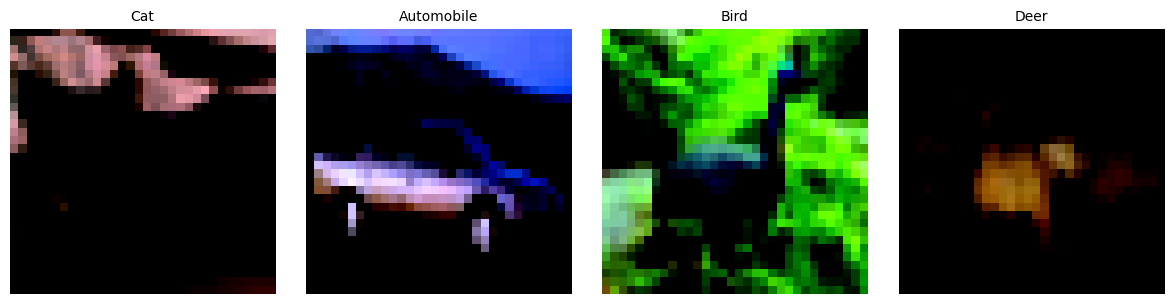

In [22]:
# Conditions
conditions = ['Cat', 'Automobile', 'Bird', 'Deer']

# Generate and display conditioned images
fig, axes = plt.subplots(1, len(conditions), figsize=(12, 3))

for idx, condition in enumerate(conditions):
    conditioned_image = generate_conditioned_image(condition, train_dataset, label_names)
    axes[idx].imshow(conditioned_image)  # Display the conditioned image
    axes[idx].set_title(condition, fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


**Conditional Image Generation (For User Input)**

In [12]:
def generate_conditioned_image(condition, dataset, label_names):
    """
    Generates a conditioned image by modifying colors of an image from CIFAR-10.
    Args:
        condition (str): The condition to apply (e.g., "Cat", "Automobile").
        dataset (Dataset): The CIFAR-10 dataset.
        label_names (list): List of label names corresponding to the dataset.
    Returns:
        numpy.ndarray: A conditioned color image (HWC format).
    """
    # Ensure condition matches a valid label
    condition = condition.capitalize()
    if condition not in label_names:
        raise ValueError(f"Invalid condition: {condition}. Please enter one of {label_names}.")

    # Find index of the condition in label names
    condition_index = label_names.index(condition)

    # Select an image matching the condition
    for image, label in dataset:
        if label == condition_index:
            # Convert image to NumPy array for modification
            image_np = image.numpy().transpose(1, 2, 0)  # Convert to HWC
            break

    # Apply condition-specific color modifications
    if condition.lower() == 'cat':
        image_np[:, :, 0] *= 1.5  # Enhance the red channel
    elif condition.lower() == 'automobile':
        image_np[:, :, 2] *= 1.5  # Enhance the blue channel
    elif condition.lower() == 'bird':
        image_np[:, :, 1] *= 1.5  # Enhance the green channel
    else:
        image_np *= 0.8  # Slightly dim images for unknown conditions

    # Clip values to valid range [0, 1]
    image_np = np.clip(image_np, 0, 1)
    return image_np

**Interactive User Input and Display**


Menu:
1. Enter a condition to generate a colored image
2. Quit
Enter your choice (1 or 2): 1
Available conditions: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck
Enter a condition (e.g., Cat, Bird, Automobile): Dog


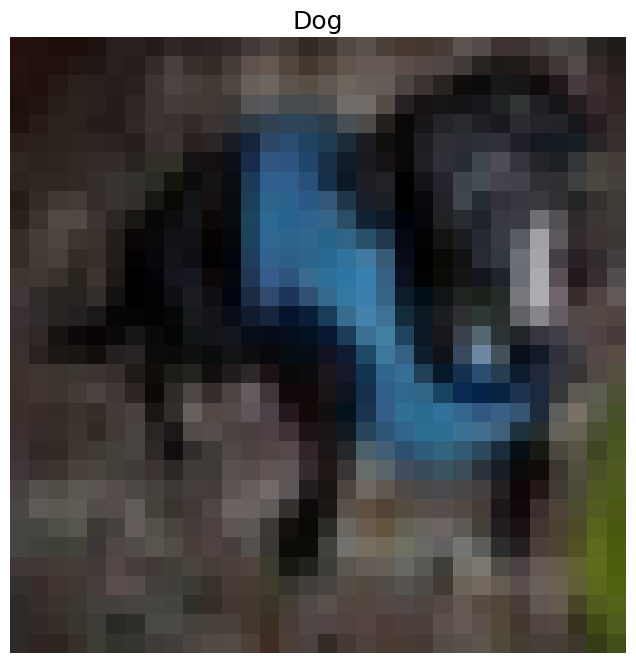


Menu:
1. Enter a condition to generate a colored image
2. Quit
Enter your choice (1 or 2): 1
Available conditions: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck
Enter a condition (e.g., Cat, Bird, Automobile): Horse



Menu:
1. Enter a condition to generate a colored image
2. Quit
Enter your choice (1 or 2): 2
Exiting the program. Goodbye!


In [13]:
# Allow the user to interact with a menu to input conditions repeatedly or quit
label_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def display_menu():
    print("\nMenu:")
    print("1. Enter a condition to generate a colored image")
    print("2. Quit")

def interactive_image_generation():
    while True:
        display_menu()
        choice = input("Enter your choice (1 or 2): ").strip()

        if choice == '1':
            print(f"Available conditions: {', '.join(label_names)}")
            user_input = input("Enter a condition (e.g., Cat, Bird, Automobile): ").strip()

            try:
                # Generate the conditioned image based on user input
                conditioned_image = generate_conditioned_image(user_input, dataset, label_names)

                # Display the conditioned image (resized for clarity)
                plt.figure(figsize=(8, 8))
                plt.imshow(conditioned_image, interpolation='nearest')  # Use nearest interpolation for better clarity
                plt.title(user_input.capitalize(), fontsize=18)
                plt.axis('off')
                plt.show()
            except ValueError as e:
                print(e)
        elif choice == '2':
            print("Exiting the program. Goodbye!")
            break
        else:
            print("Invalid choice. Please enter 1 or 2.")

# Start the interactive session
interactive_image_generation()
